In [2]:
import pandas as pd
import numpy as np
import plotly.express as px
import os 
import json
import sys

from functools import lru_cache

from botocore.exceptions import ClientError

In [3]:
# Tells the location of folders (e.g. aws folder) - creates a path
from user_path import set_up_path 

PATH = set_up_path()
sys.path.append(PATH['tools'])
sys.path.append(PATH['tools'] + '/functions')


In [4]:
# Importing custom libraries to connect to DWS and GSheet
from functions.database import get_data_from_warehouse
from utils.gspread.gsheet_data import GetSheetData

In [40]:
# Just checking if connected
query = """select COUNT(DISTINCT stuart_package_id)
    
from dim.package p
WHERE pu_city = 'London'
LIMIT 10
"""
data = get_data_from_warehouse(query)

Connected to the DataWarehouse
Result from query obtained
Data stored in dataframe


In [ ]:
data

# Catchment areas (CAs) and Pools

In [5]:
from password_downloader import get_passwords
# Gets a bunch of passwords. Here is specifically for the uk
PASSWORDS = get_passwords('uk') 

# PASSWORDS helps to get a connection to GSheet???
sheet = GetSheetData(DICT=PASSWORDS['gsheet_client_secret'])

In [6]:
# Connecting to GSheet
sheet_name = 'Sourcing / Onboarding Catchment Areas'

# Indicates which GSheet workbook I need
tab = 'OB Revamp Mapping'
catch_areas = sheet.worksheet_data(sheet_name, tab)

In [76]:
catch_areas.head()

,City,Sourcing / OB Catchment Areas,StuartPoolswithinCatchmentArea,,,,,,,,
0,Basildon,Basildon,BasildonCentral,Laindon,Pitsea,,,,,,
1,Birmingham,Birmingham Central,BirminghamCentral,BirminghamYardley,BirminghamHandsworth,,,,,,
2,Birmingham,Birmingham North,BirminghamErdington,BirminghamSuttonColdfield,,,,,,,
3,Birmingham,Birmingham East,BirminghamSolihull,BirminghamHallGreen,BirminghamAcocksGreen,,,,,,
4,Birmingham,Birmingham South,BirminghamSellyOak,Northfield,,,,,,,


In [8]:
# Pivot Longer the table
catch_areas1 = catch_areas.melt(id_vars=['City','Sourcing / OB Catchment Areas'])

In [9]:
# Dropping off City and Variable 
catch_areas1.drop(columns=['variable','City'], inplace=True) 

In [10]:
catch_areas1

,Sourcing / OB Catchment Areas,value
0,Basildon,BasildonCentral
1,Birmingham Central,BirminghamCentral
2,Birmingham North,BirminghamErdington
3,Birmingham East,BirminghamSolihull
4,Birmingham South,BirminghamSellyOak
...,...,...
733,Sunderland,
734,Teesside,
735,St Helens,
736,Warrington City,


In [11]:
# Replacing empty rows with na values and dropping them
catch_areas2 = catch_areas1.replace(r'^\s*$', np.nan, regex=True).dropna(subset=['value'])

In [12]:
catch_areas2

,Sourcing / OB Catchment Areas,value
0,Basildon,BasildonCentral
1,Birmingham Central,BirminghamCentral
2,Birmingham North,BirminghamErdington
3,Birmingham East,BirminghamSolihull
4,Birmingham South,BirminghamSellyOak
...,...,...
637,Newcastle,NewcastleRisingSun
695,London Outer E,Erith
700,London Border W,Twickenham
707,London Outer N,FinsburyPark


In [13]:
# Renaming columns
catch_areas2.rename(columns={'Sourcing / OB Catchment Areas':'catchment_area',
                            'value':'stuart_delivery_area'}, inplace=True)

In [14]:
catch_areas2

,catchment_area,stuart_delivery_area
0,Basildon,BasildonCentral
1,Birmingham Central,BirminghamCentral
2,Birmingham North,BirminghamErdington
3,Birmingham East,BirminghamSolihull
4,Birmingham South,BirminghamSellyOak
...,...,...
637,Newcastle,NewcastleRisingSun
695,London Outer E,Erith
700,London Border W,Twickenham
707,London Outer N,FinsburyPark


## PC Mapping

In [15]:
# CA and pool onboarded drivers worked in 
query = """


SELECT d.stuart_driver_id,
  --     d.applicant_fountain_id,
       uam.application_fountain_id,
       uam.postcode_found as driver_postCode,
       uam.application_pool,
       a.area_name_uscore,
   --    a.area_name_cap,
       a.area_name_clean,
       a.catchment_area,
       uam.lat as lat_driver, ---- Just in case
       uam.long as long_driver---- Just in case
 --      z.zone_name

FROM modeled

INNER JOIN ops.uk_application_mapping uam
    ON uam.application_fountain_id = d.applicant_fountain_id

LEFT JOIN ops.area a
    ON uam.application_pool = a.area_name_uscore

WHERE d.zone_id = 2
AND d.is_active = TRUE

"""
courier_mapping = get_data_from_warehouse(query)

Connected to the DataWarehouse
Result from query obtained
Data stored in dataframe


In [16]:
courier_mapping

,stuart_driver_id,application_fountain_id,driver_postcode,application_pool,area_name_uscore,area_name_clean,catchment_area,lat_driver,long_driver
0,342534,6ad7fba2-dbab-4dcc-bcd5-d6bf4cb6f35b,W3 7PQ,Acton,Acton,Acton,London Inner Lower NW,51.518375,-0.252240
1,363113,c5a86b3a-9793-4d0e-b0d5-262f7c4c9b0a,SE17 3QF,Kennington,Kennington,Kennington,London Inner E,51.487968,-0.101614
2,346884,89462909-4473-4d13-89c4-d4331e222529,N15 3PX,Wood_Green,Wood_Green,Wood Green,London Outer N,51.586530,-0.095057
3,346537,1b023183-a8bb-4fa0-b8f7-5f2edfd34421,TW5 9SD,Cranford,Cranford,Cranford,London Outer Lower NW,51.479192,-0.413286
4,345808,359b26bf-acf6-4da5-b8b5-5a7cb3f99f6b,N7 9QD,Camden,Camden,Camden,London Inner N,51.546373,-0.126110
...,...,...,...,...,...,...,...,...,...
9506,466153,31ff5644-a4cd-43f1-b169-48cafd60e2c6,E11 3ES,Leyton,Leyton,Leyton,London Outer NE,51.560615,0.014000
9507,469604,afbfed9c-2a79-489c-81c0-14b7877b46a5,SE9 5DW,Eltham,Eltham,Eltham,London Outer E,51.450411,0.058959
9508,455302,55318247-d6aa-4ce0-b45e-825d1c3f33ad,E13 8ES,Canning_Town,Canning_Town,Canning Town,London Outer NE,51.520636,0.017021
9509,477312,168d49fc-f022-4cd4-934a-1448b7d47798,DA17 6JP,Thamesmead,Thamesmead,Thamesmead,London Outer E,51.492592,0.150435


In [17]:
courier_mapping.describe()

,stuart_driver_id,lat_driver,long_driver
count,9511.000000,9450.000000,9450.000000
mean,418922.626433,51.534036,-0.166695
std,43542.664967,0.293966,0.411841
min,339072.000000,50.339817,-4.978623
25%,385963.000000,51.448604,-0.252215
50%,410763.000000,51.522007,-0.107106
75%,462710.500000,51.567456,-0.010001
max,485805.000000,56.127844,1.122188


In [18]:
courier_mapping.isnull().sum()

stuart_driver_id             0
application_fountain_id      0
driver_postcode              0
application_pool             0
area_name_uscore           942
area_name_clean            942
catchment_area             942
lat_driver                  61
long_driver                 61
dtype: int64

In [19]:
# Percentage of couriers not living in CA
not_in_CA = courier_mapping['catchment_area'].isnull().sum() * 100 / len(courier_mapping.catchment_area)
print(not_in_CA)

9.904321312164862


In [20]:
# Percentage of couriers living in CA
in_CA = courier_mapping['catchment_area'].notnull().sum() * 100 / len(courier_mapping.catchment_area)
print(in_CA)

90.09567868783513


In [21]:
courier_inCA = courier_mapping

In [49]:
courier_mapping['in_CA']= np.where(courier_mapping['catchment_area'].notnull() , 'Yes' , 'No')
courier_mapping

,stuart_driver_id,application_fountain_id,driver_postcode,application_pool,area_name_uscore,area_name_clean,catchment_area,lat_driver,long_driver,in_CA
0,342534,6ad7fba2-dbab-4dcc-bcd5-d6bf4cb6f35b,W3 7PQ,Acton,Acton,Acton,London Inner Lower NW,51.518375,-0.252240,Yes
1,363113,c5a86b3a-9793-4d0e-b0d5-262f7c4c9b0a,SE17 3QF,Kennington,Kennington,Kennington,London Inner E,51.487968,-0.101614,Yes
2,346884,89462909-4473-4d13-89c4-d4331e222529,N15 3PX,Wood_Green,Wood_Green,Wood Green,London Outer N,51.586530,-0.095057,Yes
3,346537,1b023183-a8bb-4fa0-b8f7-5f2edfd34421,TW5 9SD,Cranford,Cranford,Cranford,London Outer Lower NW,51.479192,-0.413286,Yes
4,345808,359b26bf-acf6-4da5-b8b5-5a7cb3f99f6b,N7 9QD,Camden,Camden,Camden,London Inner N,51.546373,-0.126110,Yes
...,...,...,...,...,...,...,...,...,...,...
9506,466153,31ff5644-a4cd-43f1-b169-48cafd60e2c6,E11 3ES,Leyton,Leyton,Leyton,London Outer NE,51.560615,0.014000,Yes
9507,469604,afbfed9c-2a79-489c-81c0-14b7877b46a5,SE9 5DW,Eltham,Eltham,Eltham,London Outer E,51.450411,0.058959,Yes
9508,455302,55318247-d6aa-4ce0-b45e-825d1c3f33ad,E13 8ES,Canning_Town,Canning_Town,Canning Town,London Outer NE,51.520636,0.017021,Yes
9509,477312,168d49fc-f022-4cd4-934a-1448b7d47798,DA17 6JP,Thamesmead,Thamesmead,Thamesmead,London Outer E,51.492592,0.150435,Yes


In [50]:
in_CA = courier_mapping.groupby('in_CA').agg({'stuart_driver_id':'count'}).reset_index()
in_CA

,in_CA,stuart_driver_id
0,No,942
1,Yes,8569


In [72]:
# Percentage of drivers who live within CA
in_CA['Percentage_drivers_inCA'] = (in_CA['stuart_driver_id']/in_CA['stuart_driver_id'].sum()) * 100
in_CA = in_CA.round(0)

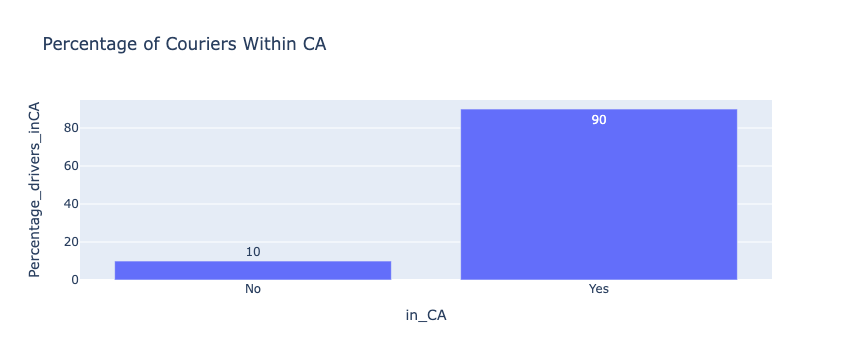

In [83]:
fig1 = px.bar(in_CA, x = 'in_CA' , y = 'Percentage_drivers_inCA', title= 'Percentage of Couriers Within CA', text = 'Percentage_drivers_inCA')
fig1.show()

In [60]:
# Top 5 CA with highest number of resident couriers
top_5_CA = courier_mapping.groupby('catchment_area').agg({'stuart_driver_id':'count'}).reset_index()
top_5_CA.head(5)

,catchment_area,stuart_driver_id
0,Altrincham,1
1,Basildon,2
2,Birmingham Central,2
3,Birmingham East,1
4,Bolton,2


In [63]:
# Sorting values in descending order
top_5_CA = top_5_CA.sort_values(by='stuart_driver_id', ascending=False)
top_5_CA.head(5)

,catchment_area,stuart_driver_id
36,London Outer NE,961
35,London Outer N,844
40,London Outer Upper NW,793
30,London Inner S,715
37,London Outer S,602


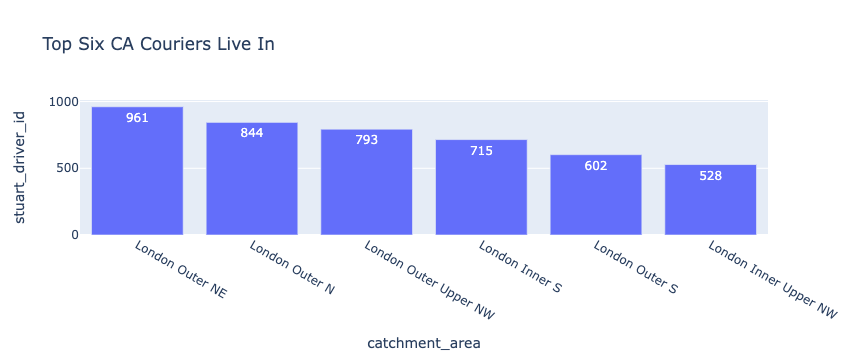

In [84]:
fig2 = px.bar(top_5_CA.head(6), x = 'catchment_area' , y = 'stuart_driver_id', title = 'Top Six CA Couriers Live In' , text = 'stuart_driver_id')
fig2.show()

## Delivery Database 

            Creating a metric to get "CA each driver mostly worked in"

In [208]:
query_2 = '''

SELECT -------------------- Package
       cd.driver_id,          -- stuart_driver_id
    MIN(cd.valid_from_date) as earliest_date,
       a.catchment_area as pu_CA,

    ------------------  Driver
       uam.postcode_found as driver_postCode,
       ad.catchment_area as driver_CA,
       count( distinct p.package_id) as no_packages,
       uam.application_fountain_id

FROM modeled_core.driver cd

INNER JOIN modeled_core.zones z
USING (zone_id)

LEFT JOIN modeled_core.delivery d
    ON cd.driver_id = d.driver_id

LEFT JOIN modeled_core.package p
    ON d.package_id = p.package_id

LEFT JOIN modeled_core.location l
    ON p.pu_location_id = l.location_id

LEFT JOIN ops.area a
    ON REPLACE(l.delivery_area_name , '_' , '') = a.area_name_cap -- pool area for packages

LEFT JOIN ops.uk_application_mapping uam
    ON uam.application_fountain_id = cd.applicant_fountain_id

LEFT JOIN ops.area ad
    ON uam.application_pool = ad.area_name_uscore   -- pool area for driver ca

WHERE z.country_id = 2
AND DATE(p.time_window_pu_start_utc) >= '2021-01-01'

GROUP BY 1, 3, 4, 5, 7

'''

deliveries = get_data_from_warehouse(query_2)

Connected to the DataWarehouse
Result from query obtained
Data stored in dataframe


In [209]:
# Getting multiple rows per driver as they can work in different catchment areas
deliveries.shape

(129633, 7)

In [210]:
no_dup_deliveries = deliveries.drop_duplicates()
no_dup_deliveries

,driver_id,earliest_date,pu_ca,driver_postcode,driver_ca,no_packages,application_fountain_id
0,15976,2016-04-11,London Inner Upper NW,None,None,4,None
1,18049,2016-05-13,London Outer Upper NW,None,None,15,None
2,18052,2016-05-13,London Inner Upper NW,None,None,2135,None
3,18052,2016-05-13,London Outer N,None,None,1,None
4,21334,2016-07-19,London Inner E,None,None,3,None
...,...,...,...,...,...,...,...
129628,490706,2021-12-17,St Helens,WA9 2BE,St Helens,25,67ea9a44-44a2-4462-82e1-f3d68ab8d044
129629,490810,2021-12-17,Exeter,EX31 2LZ,None,21,0c70fcbd-b9ff-4cd4-950f-8c9e4d1fef24
129630,490810,2021-12-17,None,EX31 2LZ,None,11,0c70fcbd-b9ff-4cd4-950f-8c9e4d1fef24
129631,491945,2021-12-20,London Inner N,None,None,17,None


In [211]:
no_dup_deliveries['driver_id'].nunique()

45035

In [212]:
no_dup_deliveries = no_dup_deliveries[no_dup_deliveries['application_fountain_id'].isnull()==False]
no_dup_deliveries['driver_id'].nunique()

# 45035

16273

In [214]:
# Number of drivers who are not considered due to application_id
(45035 - 16273)/45035 * 100

63.86588209170645

In [215]:
# Generating a csv file with drivers and their deliveries
no_dup_deliveries.to_csv('data/deliveries_and_catchement_areas.csv' , index = False )

# Another way deliveries.to_csv('deliveries.csv') 

In [216]:
# Dropped all None values in driver_ca: Removing drivers who don't live in CA
no_dup_deliveries = no_dup_deliveries[no_dup_deliveries['driver_ca'].isnull()==False]

In [217]:
no_dup_deliveries['driver_id'].nunique()

13463

In [218]:
no_dup_deliveries.head(10)

,driver_id,earliest_date,pu_ca,driver_postcode,driver_ca,no_packages,application_fountain_id
12740,339107,2021-01-06,London Outer N,N8 9JT,London Outer N,1,92a79bc5-2bcc-40fe-92fc-c4dead46f15a
12783,339657,2021-01-07,London Outer NE,N22 5AG,London Outer N,1,59dc59e6-13bc-496d-93ec-64df7090f031
12788,339680,2021-01-07,London Border NE,E12 6NX,London Outer NE,1,53cde956-986b-40ac-8b09-0912c8ea2918
12789,339714,2021-01-07,London Inner N,E1 1BF,London Inner N,16,7f937df5-af27-45f5-be69-27510d754e04
12796,339748,2021-01-07,London Inner E,NW10 3NU,London Inner Upper NW,1,53f397a5-86c5-43a4-b7c3-9b54ebf9a6cc
12797,339748,2021-01-07,London Outer N,NW10 3NU,London Inner Upper NW,1,53f397a5-86c5-43a4-b7c3-9b54ebf9a6cc
12799,339756,2021-01-07,London Inner Upper NW,N7 8DJ,London Inner N,8,65f7c3c2-7134-4c19-943f-78496df2f25a
12800,339756,2021-01-07,London Outer N,N7 8DJ,London Inner N,12,65f7c3c2-7134-4c19-943f-78496df2f25a
12801,339756,2021-01-07,London Outer NE,N7 8DJ,London Inner N,1,65f7c3c2-7134-4c19-943f-78496df2f25a
12820,340016,2021-01-08,London Outer E,DA16 3PB,London Outer E,767,4b7b8694-1cb8-48fe-b8d9-3428833afd1c


In [219]:
# One driver could do deliveries in multiple CA
no_dup_deliveries.shape

(33586, 7)

In [220]:
no_dup_deliveries

,driver_id,earliest_date,pu_ca,driver_postcode,driver_ca,no_packages,application_fountain_id
12740,339107,2021-01-06,London Outer N,N8 9JT,London Outer N,1,92a79bc5-2bcc-40fe-92fc-c4dead46f15a
12783,339657,2021-01-07,London Outer NE,N22 5AG,London Outer N,1,59dc59e6-13bc-496d-93ec-64df7090f031
12788,339680,2021-01-07,London Border NE,E12 6NX,London Outer NE,1,53cde956-986b-40ac-8b09-0912c8ea2918
12789,339714,2021-01-07,London Inner N,E1 1BF,London Inner N,16,7f937df5-af27-45f5-be69-27510d754e04
12796,339748,2021-01-07,London Inner E,NW10 3NU,London Inner Upper NW,1,53f397a5-86c5-43a4-b7c3-9b54ebf9a6cc
...,...,...,...,...,...,...,...
129624,490652,2021-12-17,Bolton,BL1 8AL,Bolton,7,5fd8a8a9-6e33-4743-989b-6f84aa283e60
129626,490657,2021-12-17,Nottingham Central,NG7 3BP,Nottingham Central,24,63872249-23f0-4e12-ab9d-47cafbec948f
129627,490670,2021-12-17,Wolverhampton,WV1 1QU,Wolverhampton,17,67e745da-8f0e-4bcb-88e0-8b6686af5553
129628,490706,2021-12-17,St Helens,WA9 2BE,St Helens,25,67ea9a44-44a2-4462-82e1-f3d68ab8d044


In [221]:
# Checking exmaple
no_dup_deliveries[no_dup_deliveries['driver_id']== 412933]

,driver_id,earliest_date,pu_ca,driver_postcode,driver_ca,no_packages,application_fountain_id
39668,412933,2021-06-14,Plymouth,PL1 5AE,Plymouth,383,934961ce-3b80-4144-9287-a8257ff2a0aa
96309,412933,2021-06-14,Plymstock,PL1 5AE,Plymouth,291,934961ce-3b80-4144-9287-a8257ff2a0aa
126393,412933,2021-06-14,Milton Keynes,PL1 5AE,Plymouth,82,934961ce-3b80-4144-9287-a8257ff2a0aa


In [222]:
# New column: total number of packages each driver did
new_df = no_dup_deliveries.groupby(['driver_id', 'driver_ca']).sum('no_packages').reset_index()

# Merging two datasets
mapped = pd.merge(no_dup_deliveries, new_df, left_on = ['driver_id','driver_ca']
                  , right_on = ['driver_id','driver_ca'])
mapped

,driver_id,earliest_date,pu_ca,driver_postcode,driver_ca,no_packages_x,application_fountain_id,no_packages_y
0,339107,2021-01-06,London Outer N,N8 9JT,London Outer N,1,92a79bc5-2bcc-40fe-92fc-c4dead46f15a,1
1,339657,2021-01-07,London Outer NE,N22 5AG,London Outer N,1,59dc59e6-13bc-496d-93ec-64df7090f031,668
2,339657,2021-01-07,London Outer S,N22 5AG,London Outer N,1,59dc59e6-13bc-496d-93ec-64df7090f031,668
3,339657,2021-01-07,London Outer SE,N22 5AG,London Outer N,7,59dc59e6-13bc-496d-93ec-64df7090f031,668
4,339657,2021-01-07,London Inner E,N22 5AG,London Outer N,639,59dc59e6-13bc-496d-93ec-64df7090f031,668
...,...,...,...,...,...,...,...,...
33581,490481,2021-12-17,Wolverhampton,WV10 0BT,Wolverhampton,48,b0b31a7d-1bf3-42e6-b985-ff0d33dc4a7f,48
33582,490559,2021-12-17,Liverpool North,L20 7AW,Liverpool North,3,cc5ca43a-d160-4653-af22-b8336926f6a4,3
33583,490629,2021-12-17,Bolton,BL1 8AQ,Bolton,4,4f5fdc72-020c-46a8-b9a8-6ce77ae1e839,4
33584,490652,2021-12-17,Bolton,BL1 8AL,Bolton,7,5fd8a8a9-6e33-4743-989b-6f84aa283e60,7


In [223]:
mapped['driver_id'].nunique()

13463

In [225]:
# Renaming columns
mapped = mapped.rename(columns = {'no_packages_x' : 'nb_packages_per_CA', 'no_packages_y' : 'total_nb_packages' , 'zone_name' : 'zone_name_of_driver_pu_ca'})
mapped

,driver_id,earliest_date,pu_ca,driver_postcode,driver_ca,nb_packages_per_CA,application_fountain_id,total_nb_packages
0,339107,2021-01-06,London Outer N,N8 9JT,London Outer N,1,92a79bc5-2bcc-40fe-92fc-c4dead46f15a,1
1,339657,2021-01-07,London Outer NE,N22 5AG,London Outer N,1,59dc59e6-13bc-496d-93ec-64df7090f031,668
2,339657,2021-01-07,London Outer S,N22 5AG,London Outer N,1,59dc59e6-13bc-496d-93ec-64df7090f031,668
3,339657,2021-01-07,London Outer SE,N22 5AG,London Outer N,7,59dc59e6-13bc-496d-93ec-64df7090f031,668
4,339657,2021-01-07,London Inner E,N22 5AG,London Outer N,639,59dc59e6-13bc-496d-93ec-64df7090f031,668
...,...,...,...,...,...,...,...,...
33581,490481,2021-12-17,Wolverhampton,WV10 0BT,Wolverhampton,48,b0b31a7d-1bf3-42e6-b985-ff0d33dc4a7f,48
33582,490559,2021-12-17,Liverpool North,L20 7AW,Liverpool North,3,cc5ca43a-d160-4653-af22-b8336926f6a4,3
33583,490629,2021-12-17,Bolton,BL1 8AQ,Bolton,4,4f5fdc72-020c-46a8-b9a8-6ce77ae1e839,4
33584,490652,2021-12-17,Bolton,BL1 8AL,Bolton,7,5fd8a8a9-6e33-4743-989b-6f84aa283e60,7


In [239]:
# Reordering columns for readability
mapped = mapped[['driver_id', 'driver_postcode' , 'driver_ca' , 'pu_ca' , 'nb_packages_per_CA' , 'total_nb_packages']].copy()
mapped

,driver_id,driver_postcode,driver_ca,pu_ca,nb_packages_per_CA,total_nb_packages
0,339107,N8 9JT,London Outer N,London Outer N,1,1
1,339657,N22 5AG,London Outer N,London Outer NE,1,668
2,339657,N22 5AG,London Outer N,London Outer S,1,668
3,339657,N22 5AG,London Outer N,London Outer SE,7,668
4,339657,N22 5AG,London Outer N,London Inner E,639,668
...,...,...,...,...,...,...
33581,490481,WV10 0BT,Wolverhampton,Wolverhampton,48,48
33582,490559,L20 7AW,Liverpool North,Liverpool North,3,3
33583,490629,BL1 8AQ,Bolton,Bolton,4,4
33584,490652,BL1 8AL,Bolton,Bolton,7,7


In [259]:
# number of drives that did 0 deliveries in their own catchment area 
len(set(mapped[mapped['driver_ca'] != mapped['pu_ca']]['driver_id']).difference(mapped_filter['driver_id']))

1340

In [240]:
# Only deliveries that were in PU_CA
mapped_filter = mapped[mapped['driver_ca']== mapped['pu_ca']].copy()
mapped_filter

,driver_id,driver_postcode,driver_ca,pu_ca,nb_packages_per_CA,total_nb_packages
0,339107,N8 9JT,London Outer N,London Outer N,1,1
9,339680,E12 6NX,London Outer NE,London Outer NE,69,70
10,339714,E1 1BF,London Inner N,London Inner N,16,16
13,339748,NW10 3NU,London Inner Upper NW,London Inner Upper NW,27,36
21,339756,N7 8DJ,London Inner N,London Inner N,156,3076
...,...,...,...,...,...,...
33581,490481,WV10 0BT,Wolverhampton,Wolverhampton,48,48
33582,490559,L20 7AW,Liverpool North,Liverpool North,3,3
33583,490629,BL1 8AQ,Bolton,Bolton,4,4
33584,490652,BL1 8AL,Bolton,Bolton,7,7


In [241]:
# Percentage of delivered packages for each driver living in CA
mapped_filter['percentage_of_packages_in_Dca'] = mapped_filter['nb_packages_per_CA'] / (mapped_filter['total_nb_packages']) * 100
mapped_filter

,driver_id,driver_postcode,driver_ca,pu_ca,nb_packages_per_CA,total_nb_packages,percentage_of_packages_in_Dca
0,339107,N8 9JT,London Outer N,London Outer N,1,1,100.000000
9,339680,E12 6NX,London Outer NE,London Outer NE,69,70,98.571429
10,339714,E1 1BF,London Inner N,London Inner N,16,16,100.000000
13,339748,NW10 3NU,London Inner Upper NW,London Inner Upper NW,27,36,75.000000
21,339756,N7 8DJ,London Inner N,London Inner N,156,3076,5.071521
...,...,...,...,...,...,...,...
33581,490481,WV10 0BT,Wolverhampton,Wolverhampton,48,48,100.000000
33582,490559,L20 7AW,Liverpool North,Liverpool North,3,3,100.000000
33583,490629,BL1 8AQ,Bolton,Bolton,4,4,100.000000
33584,490652,BL1 8AL,Bolton,Bolton,7,7,100.000000


In [243]:
# Considering mostly_worked_in_ca when percentage of packages in driver CA is over 50 mapped_filter = 
mapped_filter['mostly_worked_in_driver_ca'] = np.where(mapped_filter['percentage_of_packages_in_Dca'] > 50, 1, 0)
mapped_filter = mapped_filter.round(0)

In [253]:
mapped_filter.shape

(12123, 8)

In [255]:
mapped_filter['driver_id'].nunique()

12123

In [244]:
mapped_filter.describe()
# 81% of drivers who live in CA mostly do deliveries in their CA

,driver_id,nb_packages_per_CA,total_nb_packages,percentage_of_packages_in_Dca,mostly_worked_in_driver_ca
count,12123.000000,12123.000000,12123.000000,12123.000000,12123.000000
mean,421857.161511,525.557288,707.198878,79.020292,0.808051
std,41423.285667,855.984669,984.094792,32.806640,0.393850
min,339107.000000,1.000000,1.000000,0.000000,0.000000
25%,391510.500000,26.000000,58.000000,72.000000,1.000000
50%,419460.000000,149.000000,277.000000,98.000000,1.000000
75%,459557.000000,621.000000,987.000000,100.000000,1.000000
max,492769.000000,8918.000000,10432.000000,100.000000,1.000000


# Most Deliveries Metric

### Metric 2: Create a column: mostly_worked_in_ca by choosing the CA where a courier did his most deliveries in. 
### Then compare if this CA is the same as driver ca as 1 or 0. 
### Then calculate the % of 1s 

In [245]:
mapped

,driver_id,driver_postcode,driver_ca,pu_ca,nb_packages_per_CA,total_nb_packages
0,339107,N8 9JT,London Outer N,London Outer N,1,1
1,339657,N22 5AG,London Outer N,London Outer NE,1,668
2,339657,N22 5AG,London Outer N,London Outer S,1,668
3,339657,N22 5AG,London Outer N,London Outer SE,7,668
4,339657,N22 5AG,London Outer N,London Inner E,639,668
...,...,...,...,...,...,...
33581,490481,WV10 0BT,Wolverhampton,Wolverhampton,48,48
33582,490559,L20 7AW,Liverpool North,Liverpool North,3,3
33583,490629,BL1 8AQ,Bolton,Bolton,4,4
33584,490652,BL1 8AL,Bolton,Bolton,7,7


In [246]:
# New df is the same as mapped
new_metric = mapped.copy()
new_metric

,driver_id,driver_postcode,driver_ca,pu_ca,nb_packages_per_CA,total_nb_packages
0,339107,N8 9JT,London Outer N,London Outer N,1,1
1,339657,N22 5AG,London Outer N,London Outer NE,1,668
2,339657,N22 5AG,London Outer N,London Outer S,1,668
3,339657,N22 5AG,London Outer N,London Outer SE,7,668
4,339657,N22 5AG,London Outer N,London Inner E,639,668
...,...,...,...,...,...,...
33581,490481,WV10 0BT,Wolverhampton,Wolverhampton,48,48
33582,490559,L20 7AW,Liverpool North,Liverpool North,3,3
33583,490629,BL1 8AQ,Bolton,Bolton,4,4
33584,490652,BL1 8AL,Bolton,Bolton,7,7


In [ ]:
new_metric.dr

In [249]:
new_metric['max_ca_deliveries']= new_metric.groupby(['driver_id'])['nb_packages_per_CA'].transform(max)
new_metric

,driver_id,driver_postcode,driver_ca,pu_ca,nb_packages_per_CA,total_nb_packages,max_ca_deliveries
0,339107,N8 9JT,London Outer N,London Outer N,1,1,1
1,339657,N22 5AG,London Outer N,London Outer NE,1,668,639
2,339657,N22 5AG,London Outer N,London Outer S,1,668,639
3,339657,N22 5AG,London Outer N,London Outer SE,7,668,639
4,339657,N22 5AG,London Outer N,London Inner E,639,668,639
...,...,...,...,...,...,...,...
33581,490481,WV10 0BT,Wolverhampton,Wolverhampton,48,48,48
33582,490559,L20 7AW,Liverpool North,Liverpool North,3,3,3
33583,490629,BL1 8AQ,Bolton,Bolton,4,4,4
33584,490652,BL1 8AL,Bolton,Bolton,7,7,7


In [250]:
# Metric 2: Create a column: mostly_worked_in_ca by choosing the CA where a courier did his most deliveries in. 

new_metric2 = new_metric[new_metric['nb_packages_per_CA'] == new_metric['max_ca_deliveries']].copy()
new_metric2


,driver_id,driver_postcode,driver_ca,pu_ca,nb_packages_per_CA,total_nb_packages,max_ca_deliveries
0,339107,N8 9JT,London Outer N,London Outer N,1,1,1
4,339657,N22 5AG,London Outer N,London Inner E,639,668,639
9,339680,E12 6NX,London Outer NE,London Outer NE,69,70,69
10,339714,E1 1BF,London Inner N,London Inner N,16,16,16
13,339748,NW10 3NU,London Inner Upper NW,London Inner Upper NW,27,36,27
...,...,...,...,...,...,...,...
33581,490481,WV10 0BT,Wolverhampton,Wolverhampton,48,48,48
33582,490559,L20 7AW,Liverpool North,Liverpool North,3,3,3
33583,490629,BL1 8AQ,Bolton,Bolton,4,4,4
33584,490652,BL1 8AL,Bolton,Bolton,7,7,7


In [271]:
new_metric2[new_metric2['driver_id'].duplicated()]['driver_id']

694      342848
825      345988
1226     350251
1227     350251
2718     365761
          ...  
31915    455396
32170    469442
32404    481436
33081    444184
33264    462700
Name: driver_id, Length: 89, dtype: int64

In [ ]:
########### Can just drop duplicate drivers id

In [269]:
new_metric2[new_metric2['driver_id'] == 490559]

,driver_id,driver_postcode,driver_ca,pu_ca,nb_packages_per_CA,total_nb_packages,max_ca_deliveries,is_same
33582,490559,L20 7AW,Liverpool North,Liverpool North,3,3,3,1


In [254]:
new_metric2['driver_id'].nunique()

13463

In [251]:
# Then compare if this CA is the same as driver ca as 1 or 0. 
new_metric2['is_same'] = np.where(new_metric2['pu_ca'] == new_metric2['driver_ca'], 1, 0)
new_metric2

,driver_id,driver_postcode,driver_ca,pu_ca,nb_packages_per_CA,total_nb_packages,max_ca_deliveries,is_same
0,339107,N8 9JT,London Outer N,London Outer N,1,1,1,1
4,339657,N22 5AG,London Outer N,London Inner E,639,668,639,0
9,339680,E12 6NX,London Outer NE,London Outer NE,69,70,69,1
10,339714,E1 1BF,London Inner N,London Inner N,16,16,16,1
13,339748,NW10 3NU,London Inner Upper NW,London Inner Upper NW,27,36,27,1
...,...,...,...,...,...,...,...,...
33581,490481,WV10 0BT,Wolverhampton,Wolverhampton,48,48,48,1
33582,490559,L20 7AW,Liverpool North,Liverpool North,3,3,3,1
33583,490629,BL1 8AQ,Bolton,Bolton,4,4,4,1
33584,490652,BL1 8AL,Bolton,Bolton,7,7,7,1


In [252]:
# Then calculate the % of 1s 
new_metric2.describe()

# 74% of drivers who live in CA mostly do deliveries in their CA

,driver_id,nb_packages_per_CA,total_nb_packages,max_ca_deliveries,is_same
count,13552.000000,13552.000000,13552.000000,13552.000000,13552.000000
mean,422719.142562,627.427243,692.567223,627.427243,0.735906
std,41748.039462,908.302954,979.248120,908.302954,0.440866
min,339107.000000,1.000000,1.000000,1.000000,0.000000
25%,392640.750000,45.000000,51.000000,45.000000,0.000000
50%,420223.000000,231.000000,261.000000,231.000000,1.000000
75%,462364.250000,856.250000,956.250000,856.250000,1.000000
max,492769.000000,8918.000000,10432.000000,8918.000000,1.000000


# Drivers who did not live in CA

In [ ]:
# need a Predicted_CA column from ops.uk_applicant

In [261]:
query_3 = '''
SELECT -------------------- Package
       cd.driver_id,          -- stuart_driver_id
    MIN(cd.valid_from_date) as earliest_date,
       a.catchment_area as pu_CA,

    ------------------  Driver
    predicted_catchment_area as predicted_driver_CA,
       count( distinct p.package_id) as no_packages

FROM modeled_core.driver cd

INNER JOIN modeled_core.zones z
USING (zone_id)

LEFT JOIN modeled_core.delivery d
    ON cd.driver_id = d.driver_id

LEFT JOIN modeled_core.package p
    ON d.package_id = p.package_id

LEFT JOIN modeled_core.location l
    ON p.pu_location_id = l.location_id

LEFT JOIN ops.area a
    ON REPLACE(l.delivery_area_name , '_' , '') = a.area_name_cap -- pool area for packages

LEFT JOIN ops.uk_applicants_info uai
    ON uai.applicant_fountain_id = cd.applicant_fountain_id

WHERE z.country_id = 2
AND DATE(p.time_window_pu_start_utc) >= '2021-09-01'

GROUP BY 1, 3, 4

'''


predicted = get_data_from_warehouse(query_3)

Connected to the DataWarehouse
Result from query obtained
Data stored in dataframe


In [262]:
predicted.shape

(76194, 5)